In [150]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

In [2]:
# Load your dataset
data = pd.read_csv("data.csv", sep=";")

In [3]:
# Define a list of categorical variables
categorical_variables = ["marital", "education", "default",
                         "housing", "loan", "contact", "poutcome", "class"]

# Convert categorical variables to pandas categoricals
label_encoder = LabelEncoder()

for column in categorical_variables:
    data[column] = label_encoder.fit_transform(data[column])

               age      marital    education      default       balance  \
count  7864.000000  7864.000000  7864.000000  7864.000000   7864.000000   
mean     40.803535     1.199517     1.206511     0.007121   1553.184385   
std      11.292293     0.621375     0.649658     0.084091   3082.329608   
min      18.000000     0.000000     0.000000     0.000000  -1884.000000   
25%      32.000000     1.000000     1.000000     0.000000    162.750000   
50%      38.000000     1.000000     1.000000     0.000000    596.000000   
75%      47.000000     2.000000     2.000000     0.000000   1740.000000   
max      89.000000     2.000000     2.000000     1.000000  81204.000000   

           housing         loan      contact     poutcome        class  
count  7864.000000  7864.000000  7864.000000  7864.000000  7864.000000  
mean      0.629069     0.138606     0.075025     0.583545     0.228383  
std       0.483085     0.345557     0.263449     0.777163     0.419817  
min       0.000000     0.000000 

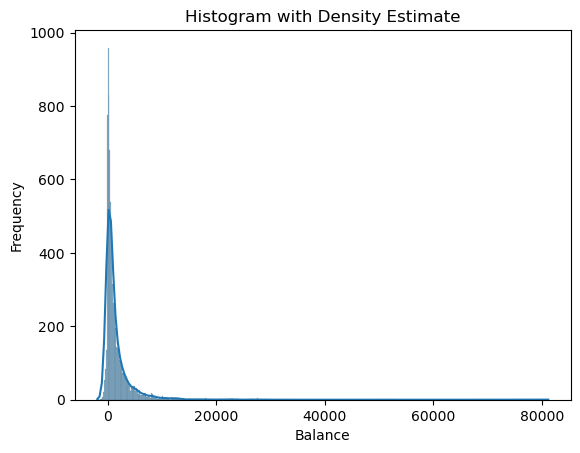

In [92]:
# Exploratory data analysis
# Overall summary
print(data.describe())

# Search for any missing values
missing_count = data.isnull().sum()
print(missing_count)  # No missing data in our database

# Distributions of observations
sns.histplot(data['balance'], kde=True)
plt.title("Histogram with Density Estimate")
plt.xlabel("Balance")
plt.ylabel("Frequency")
plt.show()

In [151]:
np.random.seed(1234)

X = data.drop(columns=['class'])
y = data['class']
X_train, X_test = train_test_split(X, test_size=0.3)
y_train, y_test = train_test_split(y, test_size=0.3)

selector = SelectKBest(k=5)
selector.fit_transform(X_train, y_train)
feature_names = selector.get_feature_names_out()
print("Best 5 features:", feature_names)

X_train = X_train[feature_names]
X_test = X_test[feature_names]

Best 5 features: ['education' 'default' 'balance' 'housing' 'loan']


In [152]:
# Define the hyperparameter grid
param_grid = {
    "criterion": ["entropy"],
    "max_depth": np.arange(2, 15),
    "min_samples_split": np.arange(2, 15, 2),
    "min_samples_leaf": np.arange(1, 11),
    # lower and upper bound of `alpha` were found by a bit of manual trial and error
    "ccp_alpha": np.arange(0, 0.001, 0.0001)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=kf)
model.fit(X_train, y_train)

best_model = model.best_estimator_
best_params = model.best_params_

y_pred = best_model.predict(X_test)
print("Best Hyperparameters:", best_params)
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Best Hyperparameters: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1841
           1       0.00      0.00      0.00       519

    accuracy                           0.78      2360
   macro avg       0.39      0.50      0.44      2360
weighted avg       0.61      0.78      0.68      2360

Confusion matrix:
[[1841    0]
 [ 519    0]]
Accuracy: 0.7800847457627119


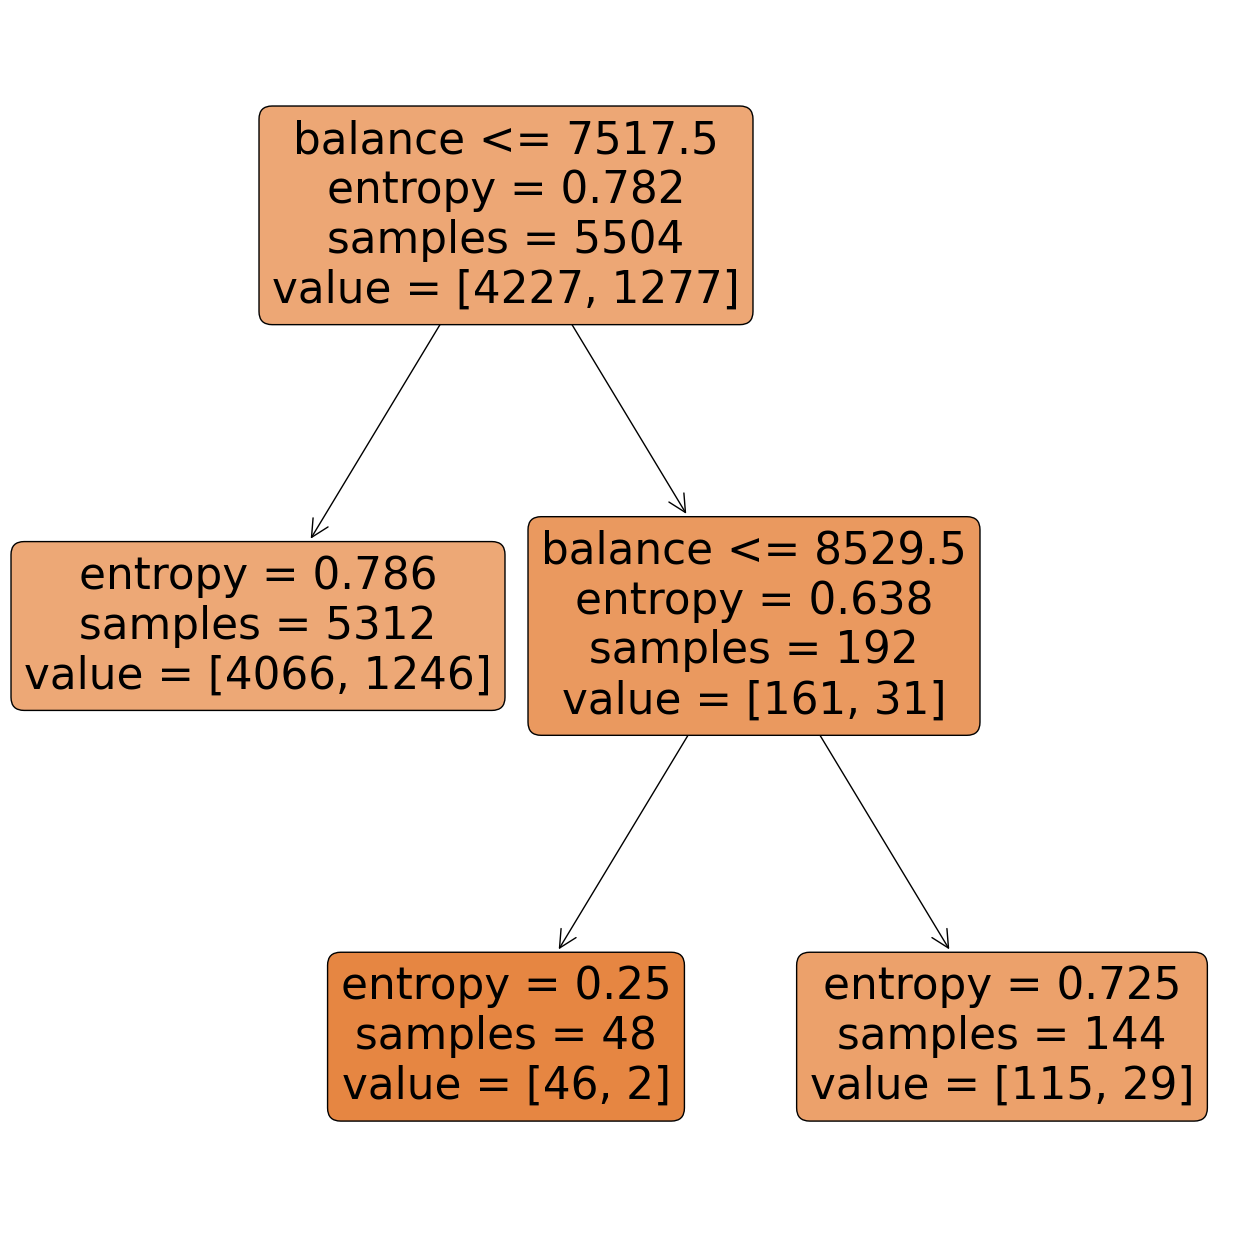

In [149]:
plt.figure(figsize=(16, 16))
plot_tree(best_model, feature_names=['education', 'default', 'balance', 'housing', 'loan'], rounded=True, filled=True)
plt.show()

In [153]:
path=best_model.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities=path.ccp_alphas, path.impurities

clfs=[]
for ccp_alpha in ccp_alphas:
    clf=DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train,y_train)
    clfs.append(clf)

print("Last node in Decision tree is {} and ccp_alpha for last node is {}".format(clfs[-1].tree_.node_count,ccp_alphas[-1]))

Last node in Decision tree is 1 and ccp_alpha for last node is 0.0009488006010310301


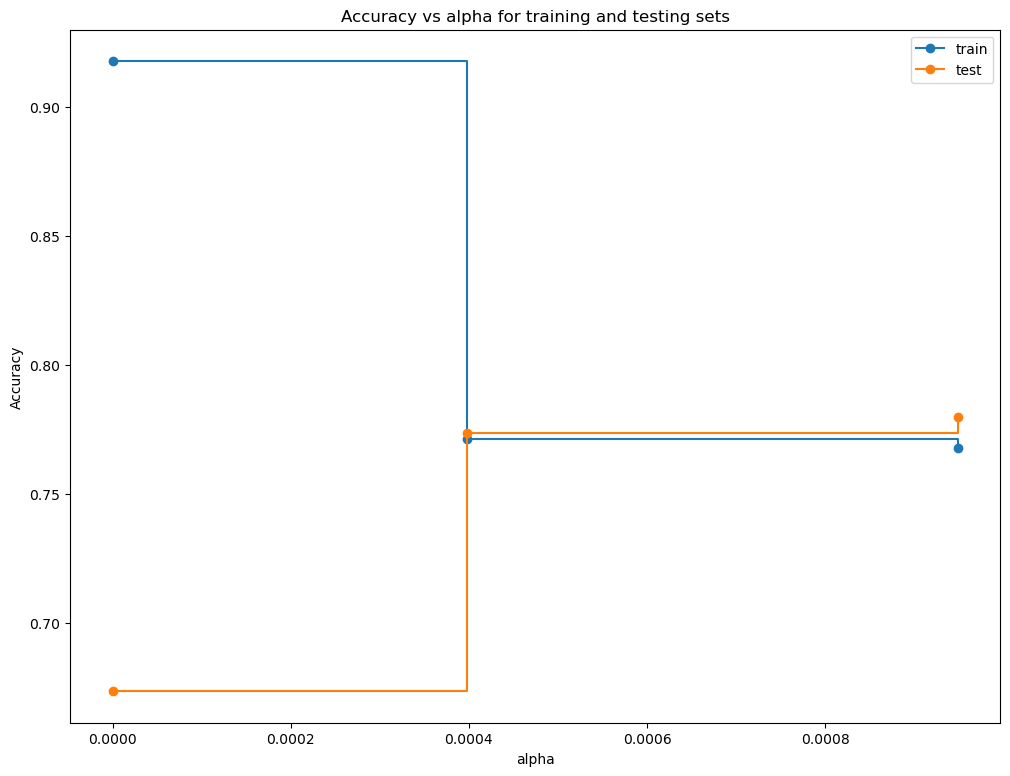

In [154]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]
fig, ax = plt.subplots(figsize=(12, 9))
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

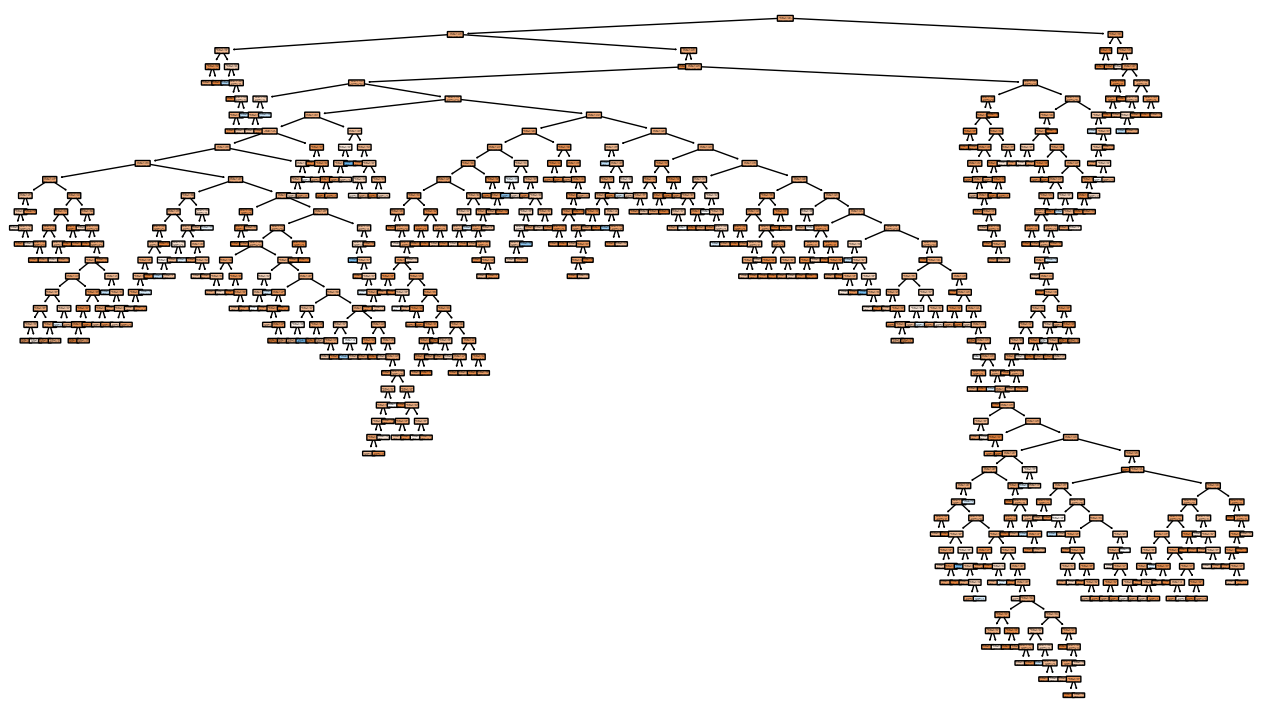

In [159]:
clf=DecisionTreeClassifier(random_state=0, criterion='entropy',
                           ccp_alpha=0.0001, min_samples_split=2,
                           min_samples_leaf=9)
clf.fit(X_train,y_train)
plt.figure(figsize=(16, 9))
plot_tree(clf, feature_names=['education', 'default', 'balance', 'housing', 'loan'], rounded=True, filled=True)
plt.show()

In [160]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

0.7309322033898306
[[1694  147]
 [ 488   31]]


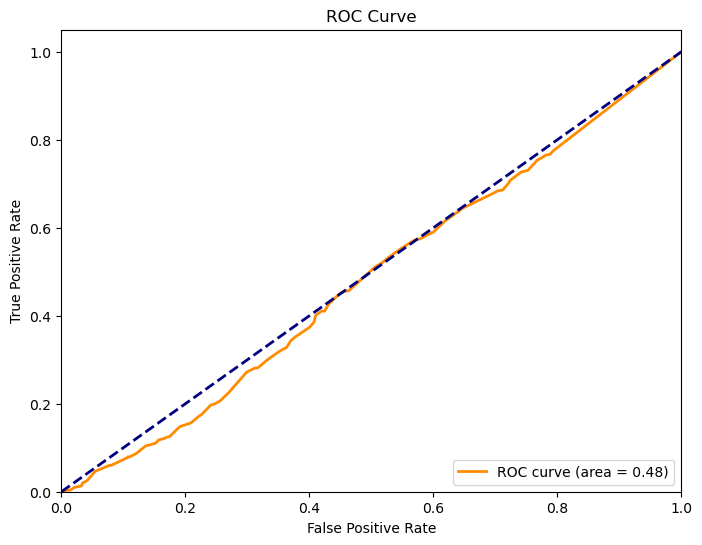

In [161]:
y_pred_proba = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()